# Overview

There are two evolutionary algorithms built into TPOT2, which corresponds to two different estimator classes.

1. The `tpot2.TPOTEstimator` uses a standard evolutionary algorithm that evaluates exactly population_size individuals each generation. This is similar to the algorithm in TPOT1. The next generation does not start until the previous is completely finished evaluating. This leads to underutilized CPU time as the cores are waiting for the last individuals to finish training, but may preserve diversity in the population. 

2. The `tpot2.TPOTEstimatorSteadyState` differs in that it will generate and evaluate the next individual as soon as an individual finishes evaluation. The number of individuals being evaluated is determined by the n_jobs parameter. There is no longer a concept of generations. The population_size parameter now refers to the size of the list of evaluated parents. When an individual is evaluated, the selection method updates the list of parents. This allows more efficient utilization when using multiple cores.


Additionally, two other simplified estimators are provided. These have a simplified set of hyperparameters with default values set for classification and regression problems. Currently, both of these use the standard evolutionary algorithm in the `tpot2.TPOTEstimator` class.

1. `tpot2.TPOTClassifier` for classification tasks
2. `tpot2.TPOTRegressor` for regression tasks

### Best Practices

When running tpot from an .py script, it is important to protect code with `if __name__=="__main__":`

In [19]:
#my_analysis.py

from dask.distributed import Client, LocalCluster
import tpot2
import sklearn
import sklearn.datasets
import numpy as np

if __name__=="__main__":
    scorer = sklearn.metrics.get_scorer('roc_auc_ovr')
    X, y = sklearn.datasets.load_digits(return_X_y=True)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
    est = tpot2.TPOTEstimatorSteadyState( 
                            scorers=['roc_auc_ovr'], #scorers can be a list of strings or a list of scorers. These get evaluated during cross validation. 
                            scorers_weights=[1],

                            classification=True,

                            max_eval_time_seconds=15,
                            max_time_seconds=30,
                            verbose=2)
    est.fit(X_train, y_train)
    print(scorer(est, X_test, y_test))

Evaluations: : 19it [00:30,  1.59s/it]


0.9996046124012956


### Common parameters

        scorers : (list, scorer)
            A scorer or list of scorers to be used in the cross-validation process. 
            see https://scikit-learn.org/stable/modules/model_evaluation.html
        
        scorers_weights : list
            A list of weights to be applied to the scorers during the optimization process.
        
        classification : bool
            If True, the problem is treated as a classification problem. If False, the problem is treated as a regression problem.
            Used to determine the CV strategy.
        
        cv : int, cross-validator
            - (int): Number of folds to use in the cross-validation process. By uses the sklearn.model_selection.KFold cross-validator for regression and StratifiedKFold for classification. In both cases, shuffled is set to True.
            - (sklearn.model_selection.BaseCrossValidator): A cross-validator to use in the cross-validation process.
                - max_depth (int): The maximum depth from any node to the root of the pipelines to be generated.
        
        other_objective_functions : list, default=[tpot2.objectives.estimator_objective_functions.average_path_length_objective]
            A list of other objective functions to apply to the pipeline.
        
        other_objective_functions_weights : list, default=[-1]
            A list of weights to be applied to the other objective functions.
        
        objective_function_names : list, default=None
            A list of names to be applied to the objective functions. If None, will use the names of the objective functions.
        
        bigger_is_better : bool, default=True
            If True, the objective function is maximized. If False, the objective function is minimized. Use negative weights to reverse the direction.

        
        max_size : int, default=np.inf
            The maximum number of nodes of the pipelines to be generated.
        
        linear_pipeline : bool, default=False
            If True, the pipelines generated will be linear. If False, the pipelines generated will be directed acyclic graphs.
        
        generations : int, default=50
            Number of generations to run
            
        max_time_seconds : float, default=float("inf")
            Maximum time to run the optimization. If none or inf, will run until the end of the generations.
        
        max_eval_time_seconds : float, default=60*5
            Maximum time to evaluate a single individual. If none or inf, there will be no time limit per evaluation.

        n_jobs : int, default=1
            Number of processes to run in parallel.
        
        memory_limit : str, default="4GB"
            Memory limit for each job. See Dask [LocalCluster documentation](https://distributed.dask.org/en/stable/api.html#distributed.Client) for more information.

            
        verbose : int, default=1 
            How much information to print during the optimization process. Higher values include the information from lower values.
            0. nothing
            1. progress bar
            
            3. best individual
            4. warnings
            >=5. full warnings trace
            6. evaluations progress bar. (Temporary: This used to be 2. Currently, using evaluation progress bar may prevent some instances were we terminate a generation early due to it reaching max_time_seconds in the middle of a generation OR a pipeline failed to be terminated normally and we need to manually terminate it.)
        

The following configuration dictionaries are covered in the next tutorial:

    root_config_dict
    inner_config_dict
    leaf_config_dict

### tpot2.TPOTEstimatorSteadyState

In [20]:
import tpot2
import sklearn
import sklearn.datasets

est = tpot2.TPOTEstimatorSteadyState( 
                            scorers=['roc_auc_ovr'], #scorers can be a list of strings or a list of scorers. These get evaluated during cross validation. 
                            scorers_weights=[1],

                            classification=True,

                            max_eval_time_seconds=15,
                            max_time_seconds=30,
                            verbose=2)


scorer = sklearn.metrics.get_scorer('roc_auc_ovo')
X, y = sklearn.datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))


Evaluations: : 117it [00:30,  3.85it/s]


0.9974747474747474


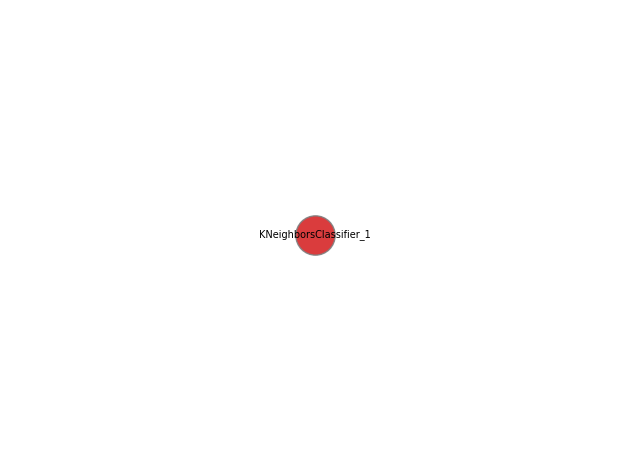

In [21]:
fitted_pipeline = est.fitted_pipeline_ # access best pipeline directly
fitted_pipeline.plot()

In [22]:
#view the summary of all evaluated individuals as a pandas dataframe
est.evaluated_individuals

,roc_auc_score,Parents,Variation_Function,Individual,Submitted Timestamp,Completed Timestamp,Pareto_Front,Instance
0,0.994405,NaN,NaN,['LogisticRegression_1'],1.692231e+09,1.692231e+09,NaN,['LogisticRegression_1']
1,0.954484,NaN,NaN,['DecisionTreeClassifier_1'],1.692231e+09,1.692231e+09,NaN,['DecisionTreeClassifier_1']
2,1.000000,NaN,NaN,['KNeighborsClassifier_1'],1.692231e+09,1.692231e+09,1.0,['KNeighborsClassifier_1']
3,0.994048,NaN,NaN,['GradientBoostingClassifier_1'],1.692231e+09,1.692231e+09,NaN,['GradientBoostingClassifier_1']
4,0.989841,NaN,NaN,['ExtraTreesClassifier_1'],1.692231e+09,1.692231e+09,NaN,['ExtraTreesClassifier_1']
...,...,...,...,...,...,...,...,...
112,0.997540,"(105, 106)",crossover,['MLPClassifier_1'],1.692231e+09,1.692231e+09,NaN,['MLPClassifier_1']
113,0.998214,"(15,)",mutate,['KNeighborsClassifier_1'],1.692231e+09,1.692231e+09,NaN,['KNeighborsClassifier_1']
114,0.997619,"(67, 67)",crossover,"[('MLPClassifier_1', 'StandardScaler_1')]",1.692231e+09,1.692231e+09,NaN,"[('MLPClassifier_1', 'StandardScaler_1')]"
115,0.996944,"(81,)",mutate,"[('ExtraTreesClassifier_1', 'RBFSampler_1'), (...",1.692231e+09,1.692231e+09,NaN,"[('ExtraTreesClassifier_1', 'RBFSampler_1'), (..."


#### Scorers, Objective Functions, and multi objective optimization.

There are two ways of passing objectives into TPOT2. 

1. `scorers`: Scorers are functions that have the signature (estimator, X, y). These can be produced with the [sklearn.metrics.make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) function. This function is used to evaluate the test folds during cross validation. These are passed into TPOT2 via the scorers parameter. This can take in the scorer itself or the string corresponding to a scoring function ([as listed here](https://scikit-learn.org/stable/modules/model_evaluation.html)). TPOT2 also supports passing in a list of several scorers for multiobjective optimization. 

2. `other_objective_functions` : Other objective functions in TPOT2 have the signature (estimator) and returns a float or list of floats. These get passed an unfitted estimator (in the case of TPOT2, a `tpot2.GraphPipeline`). 


Each scorer and objective function must be accompanied by a list of weights corresponding to the list of objectives. By default, TPOT2 maximizes objective functions (this can be changed by `bigger_is_better=False`). Positive weights means that TPOT2 will seek to maximize that objective, and negative weights correspond to minimization.

Here is an example of using two scorers

    scorers=['roc_auc_ovr',tpot2.objectives.complexity_scorer],
    scorers_weights=[1,-1],


Here is an example with a scorer and a secondary objective function

    scorers=['roc_auc_ovr'],
    scorers_weights=[1],
    other_objective_functions=[tpot2.objectives.number_of_leaves_objective],
    other_objective_functions_weights=[-1],

In [23]:
import tpot2
import sklearn
import sklearn.datasets

est = tpot2.TPOTEstimatorSteadyState( 
                            scorers=['roc_auc_ovr',tpot2.objectives.complexity_scorer],
                            scorers_weights=[1,-1],

                            classification=True,

                            max_eval_time_seconds=15,
                            max_time_seconds=30,
                            verbose=2)


scorer = sklearn.metrics.get_scorer('roc_auc_ovo')
X, y = sklearn.datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))


Evaluations: : 143it [00:30,  4.74it/s]
/home/ribeirop/miniconda3/envs/tpot2env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.9934232434232434


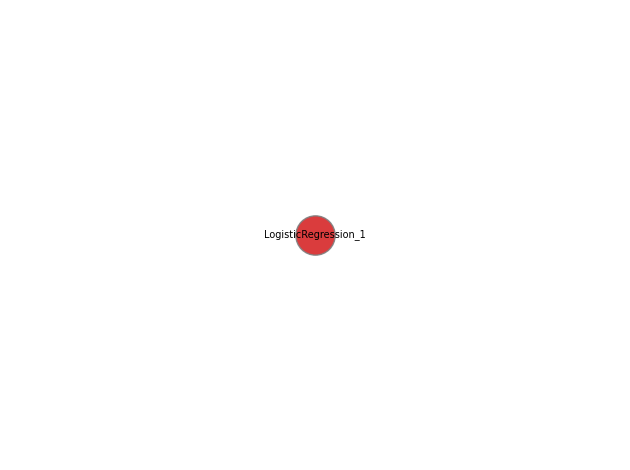

In [24]:
fitted_pipeline = est.fitted_pipeline_ # access best pipeline directly
fitted_pipeline.plot() #plot the best pipeline

view the results of all evaluated individuals as a pandas dataframe

In [25]:
est.evaluated_individuals

,roc_auc_score,complexity_scorer,Parents,Variation_Function,Individual,Submitted Timestamp,Completed Timestamp,Pareto_Front,Instance
0,1.0,15.0,NaN,NaN,['LogisticRegression_1'],1.692231e+09,1.692231e+09,NaN,['LogisticRegression_1']
1,0.96619,45.0,NaN,NaN,['DecisionTreeClassifier_1'],1.692231e+09,1.692231e+09,NaN,['DecisionTreeClassifier_1']
2,0.99746,7.0,NaN,NaN,['KNeighborsClassifier_1'],1.692231e+09,1.692231e+09,NaN,['KNeighborsClassifier_1']
3,0.996429,15064.0,NaN,NaN,['GradientBoostingClassifier_1'],1.692231e+09,1.692231e+09,NaN,['GradientBoostingClassifier_1']
4,0.995714,2802.0,NaN,NaN,['ExtraTreesClassifier_1'],1.692231e+09,1.692231e+09,NaN,['ExtraTreesClassifier_1']
...,...,...,...,...,...,...,...,...,...
138,0.5,6.0,"(98,)",mutate,"[('BernoulliNB_1', 'SelectFromModel_ExtraTrees...",1.692231e+09,1.692231e+09,NaN,"[('BernoulliNB_1', 'SelectFromModel_ExtraTrees..."
139,0.85496,1.0,"(82, 87)",crossover,['MultinomialNB_1'],1.692231e+09,1.692231e+09,NaN,['MultinomialNB_1']
140,0.997579,8210.0,"(86,)",mutate,['ExtraTreesClassifier_1'],1.692231e+09,1.692231e+09,NaN,['ExtraTreesClassifier_1']
141,0.979008,14.8,"(98,)",mutate,['SGDClassifier_1'],1.692231e+09,1.692231e+09,NaN,['SGDClassifier_1']


view pareto front as a pandas dataframe

In [26]:
est.pareto_front

,roc_auc_score,complexity_scorer,Parents,Variation_Function,Individual,Submitted Timestamp,Completed Timestamp,Pareto_Front,Instance
57,0.5,0.0,"(56,)",mutate,['LogisticRegression_1'],1.692231e+09,1.692231e+09,1.0,['LogisticRegression_1']
137,1.0,1.0,"(82,)",mutate,"[('MultinomialNB_1', 'SelectFromModel_ExtraTre...",1.692231e+09,1.692231e+09,1.0,"[('MultinomialNB_1', 'SelectFromModel_ExtraTre..."


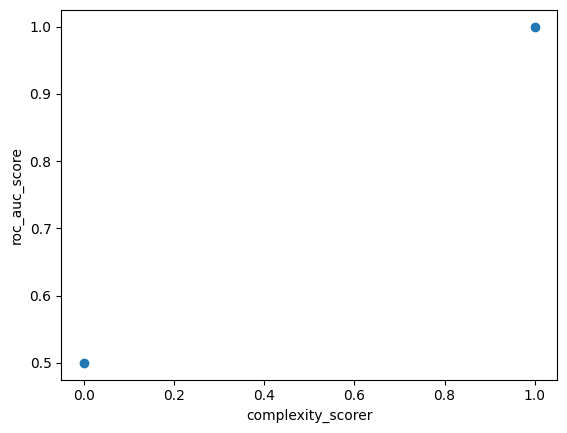

In [27]:
pareto_front = est.pareto_front

#plot the pareto front of number_of_leaves_objective vs roc_auc_score

import matplotlib.pyplot as plt
plt.scatter(pareto_front['complexity_scorer'], pareto_front['roc_auc_score'])
plt.xlabel('complexity_scorer')
plt.ylabel('roc_auc_score')
plt.show()

### tpot2.TPOTEstimator

In [28]:
import tpot2
import sklearn
import sklearn.datasets

est = tpot2.TPOTEstimator(  population_size=30,
                            generations=5,
                            scorers=['roc_auc_ovr'], #scorers can be a list of strings or a list of scorers. These get evaluated during cross validation. 
                            scorers_weights=[1],
                            classification=True,
                            n_jobs=1, 
                            early_stop=5, #how many generations with no improvement to stop after
                            
                            #List of other objective functions. All objective functions take in an untrained GraphPipeline and return a score or a list of scores
                            other_objective_functions= [ ],
                            
                            #List of weights for the other objective functions. Must be the same length as other_objective_functions. By default, bigger is better is set to True. 
                            other_objective_functions_weights=[],
                            verbose=2)

scorer = sklearn.metrics.get_scorer('roc_auc_ovo')
X, y = sklearn.datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

Generation: 100%|██████████| 5/5 [00:36<00:00,  7.20s/it]
/home/ribeirop/miniconda3/envs/tpot2env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.998015873015873


The TPOTClassifier and TPOTRegressor are set default parameters for the TPOTEstimator for Classification and Regression.
In the future, a metalearner will be used to predict the best values for a given dataset.

In [29]:
import tpot2
import sklearn
import sklearn.metrics
import sklearn.datasets

est = tpot2.tpot_estimator.templates.TPOTRegressor(n_jobs=4, max_time_seconds=10)


scorer = sklearn.metrics.get_scorer('neg_mean_squared_error')
X, y = sklearn.datasets.load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

terminating parallel evaluation due to timeout


/home/ribeirop/miniconda3/envs/tpot2env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177.4640355714364, tolerance: 143.10199053030306
  model = cd_fast.enet_coordinate_descent_gram(
/home/ribeirop/miniconda3/envs/tpot2env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185.86338704440277, tolerance: 143.10199053030306
  model = cd_fast.enet_coordinate_descent_gram(
/home/ribeirop/miniconda3/envs/tpot2env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277.49028848926537, tolerance: 143.10199053030306
  model = cd_fast.enet_coordinate_descent_gram(
/home/ribei

-2514.9527497535055


In [30]:
import tpot2
import sklearn
import sklearn.datasets

est = tpot2.tpot_estimator.templates.TPOTClassifier(n_jobs=4, max_time_seconds=10)


scorer = sklearn.metrics.get_scorer('roc_auc_ovo')
X, y = sklearn.datasets.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

terminating parallel evaluation due to timeout
0.9999694758670971
